# Census Income Project

Problem Statement:
This data was extracted from the 1994 Census bureau database https://www.census.gov/en.html by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

- A single cell estimate of the population 16+ for each state.
- Controls for Hispanic Origin by age and sex.
- Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [2]:
#importing libraries
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score

import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score,roc_curve,auc

In [3]:
#fetching the dataset
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")

In [3]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In the above cell we can see the first 5 and last 5 rows of our dataset. We see that in our dataset there are a total of 32560 rows and 15 columns present. We see a mixture of numerical data columns and text data columns that will need to be converted to numerical format before training our model. Also the problem statement says that we are suppose to predict the "Income" column that has 2 class namely "<=50K" and ">50K" so it makes this as a Classification problem!

In [5]:
df.shape

(32560, 15)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
df.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [52]:
df['Capital_gain'].value_counts().head(10)

0        29849
15024      347
7688       284
7298       246
99999      159
3103        97
5178        97
4386        70
5013        69
8614        55
Name: Capital_gain, dtype: int64

- maximum number of values are '0', which means nothing to us so we have to take care of it.
- out of 32560 rows we have 29849 rows filled with '0'

In [51]:
df['Capital_loss'].value_counts().head(10)

0       31041
1902      202
1977      168
1887      159
1485       51
1848       51
2415       49
1602       47
1740       42
1590       40
Name: Capital_loss, dtype: int64

- maximum number of values are '0', which means nothing to us so we have to take care of it.
- out of 32560 rows we have 31041 rows filled with '0'

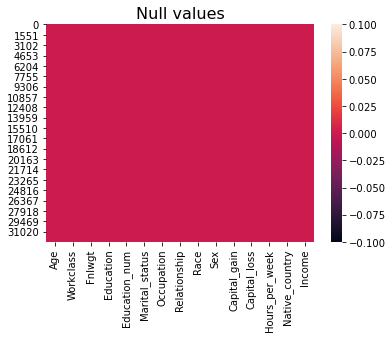

In [11]:
plt.title('Null values',fontsize=16)
sns.heatmap(df.isnull());

no null value will be visible because the nan values was been replaced with default value that is zero.

In [12]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


There is no missing value present in the numerical columns as count of each column is 32560 . minimum Age of a person who earns monney is 17 and maximun age is 90 and average age is 38.

Maybe the fnlwgt is the sampling weight,fnlwgt is not related to the target variable 'income' and will be removed before building the model.

Education column is containing number of years of education in total.

Capital gain and capital loss is maybe outcome( profit or loss ) of investment of a person other than his salary

# EDA:Exploratory Data Analysis 

In [15]:
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

In [4]:
# getting list of object data type column names
obj_dtype = df.select_dtypes(include='object')

# getting the list of float data type column names
num_dtype = df.select_dtypes(exclude='object')

In [22]:
obj_dtype

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
32555,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32556,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32557,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32558,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


In [24]:
num_dtype


,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
0,50,83311,13,0,0,13
1,38,215646,9,0,0,40
2,53,234721,7,0,0,40
3,28,338409,13,0,0,40
4,37,284582,14,0,0,40
...,...,...,...,...,...,...
32555,27,257302,12,0,0,38
32556,40,154374,9,0,0,40
32557,58,151910,9,0,0,40
32558,22,201490,9,0,0,20


In [26]:
obj_dtype

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
32555,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32556,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32557,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32558,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


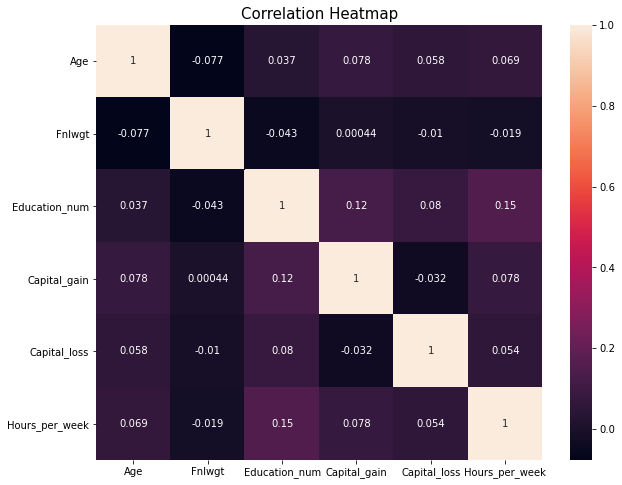

In [56]:
## correlation Plot
plt.figure(figsize=(10,8))
plt.title('Correlation Heatmap',fontsize=15)
sns.heatmap(df.corr(),annot=True);

- Fnlwgt got negative relations with other features
- captial gian and capital loss is negatively related to each other

# categorical attributes

In [58]:
for col in obj_dtype:
    print('............',col,'............')
    print(obj_dtype[col].value_counts())

............ Workclass ............
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
............ Education ............
 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64
............ Marital_status ............
 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse      

In the above cell we are taking a look at all the unique values of object data type columns. While eye balling the values we were able to see data that showed "?" in the columns "Workclass", "Occupation" and "Native_country". We will need to replace all the rows that have this "?" in them with a proper name first so that during visualizing and later on encoding these values makes more sense.

In [5]:
df['Workclass'].replace({' ?':' Other Workclass'},inplace=True)
df['Occupation'].replace({' ?':' Other Occupation'},inplace=True)
df['Native_country'].replace({' ?':' Other'},inplace=True)

# Visualization

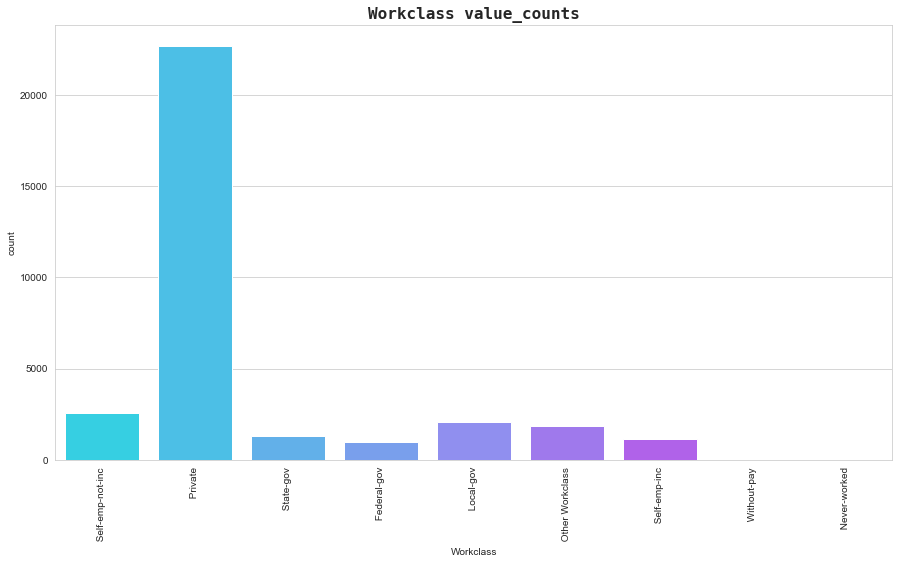

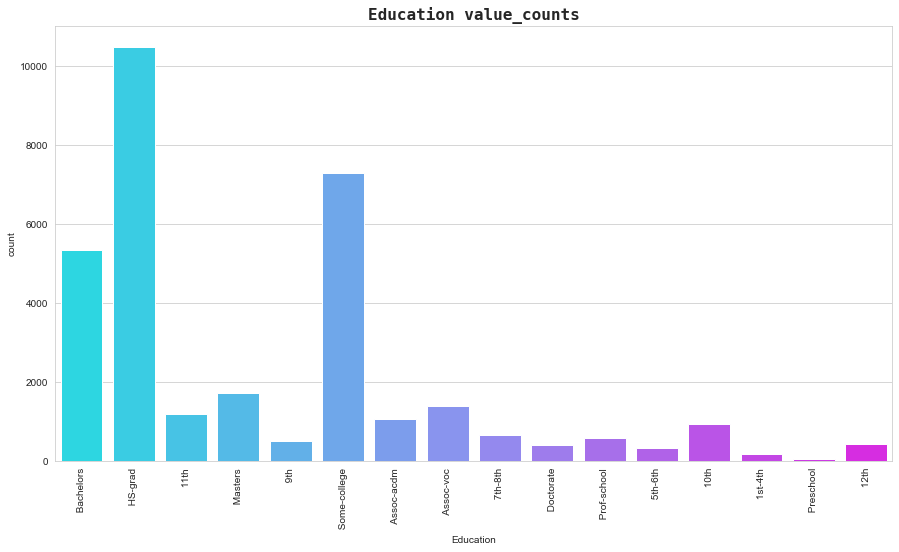

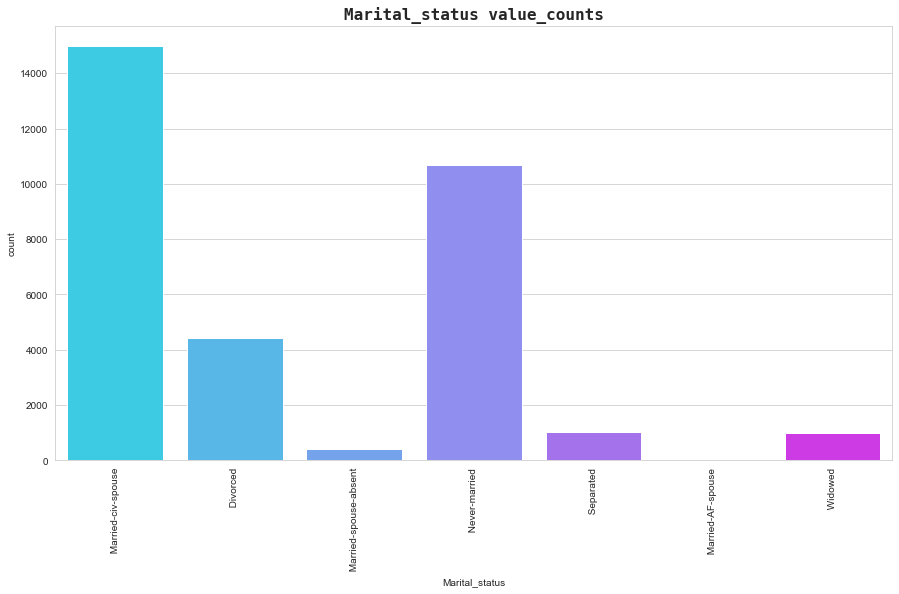

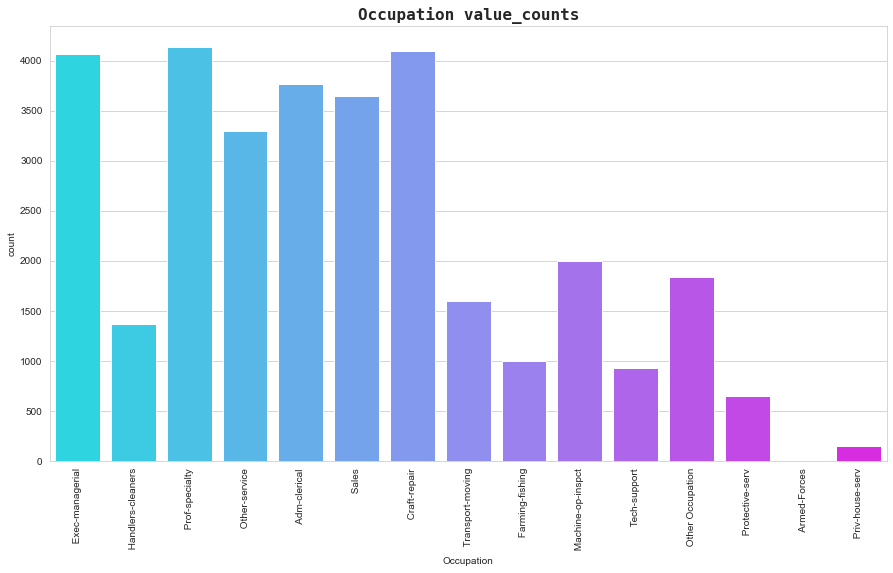

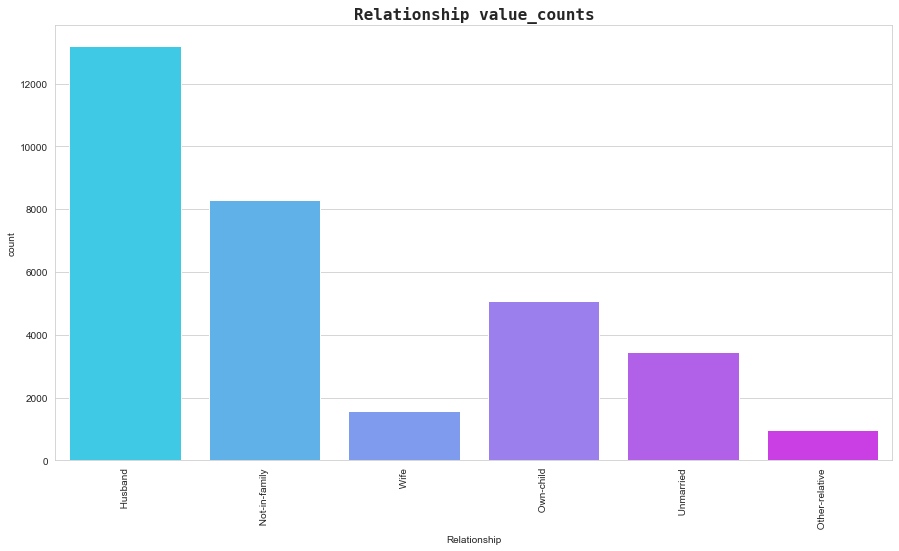

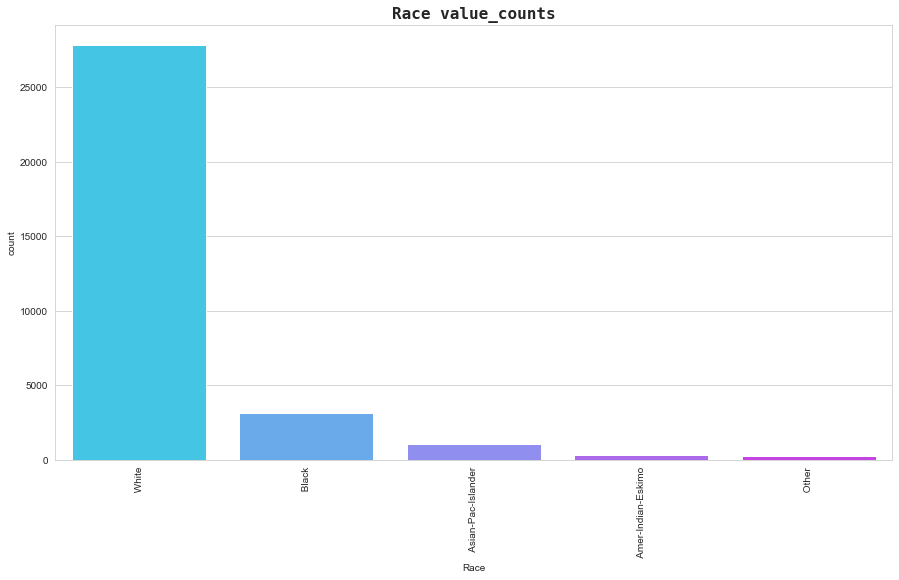

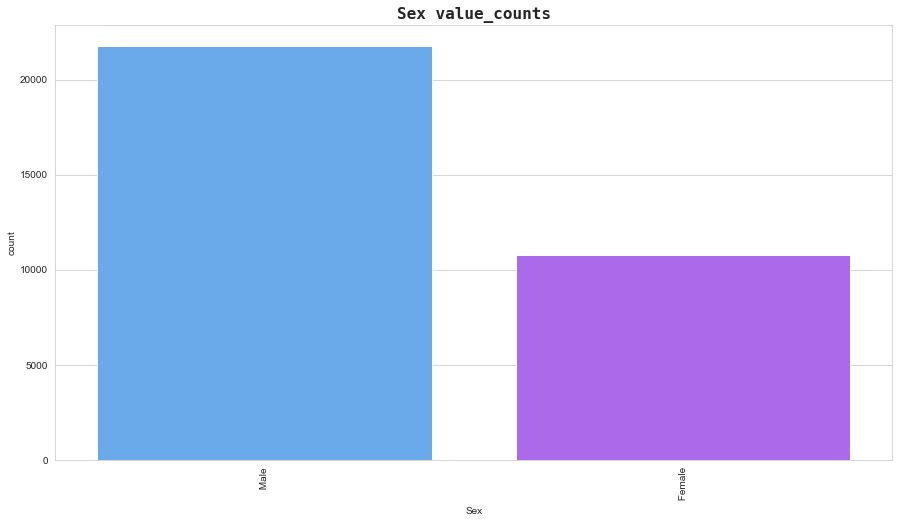

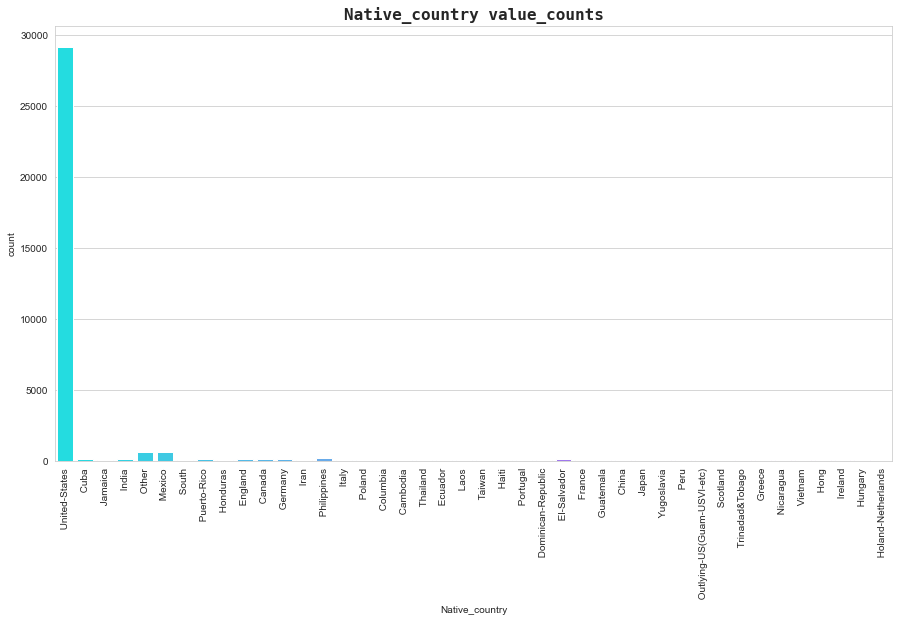

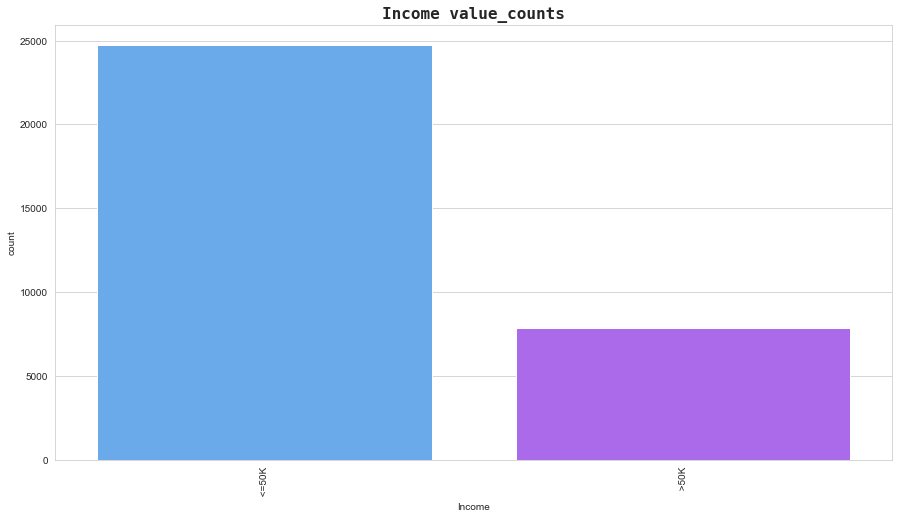

In [64]:
for col in obj_dtype:
    sns.set_style('whitegrid')
    plt.figure(figsize=(15,8))
    plt.title(col+' value_counts',fontsize=16,fontname='Monospace',fontweight='bold')
    plt.xticks(rotation=90)
    x= sns.countplot(df[col],palette='cool',data=df)
    plt.show();

workclass - The count of individuals working in a private sector is high as compared to other sectors.

education - The count of individuals having HS-grad are more follwed by the individuals having some-college, followed by bachelor people.

marital-status - The individual who married are more followed by the individuals who not-married.

occupation - The count of individuals working as a Prof-specialty id higest in the data followed by individuals working as a Craft-repair > Exec-managerial > Adm-clerical > Sales > Other-service.

relationship - The count of individuals as husband is approx. 13200 followed by individuals not-in-family as compared to other individual's relationship.

race - The count of white individuals is high.

sex - The count of females is alost half of the count of males.

native-country - The majority of individuals belongs to United-States.

income - The no. of individuals have income of more than or equal to 50k.

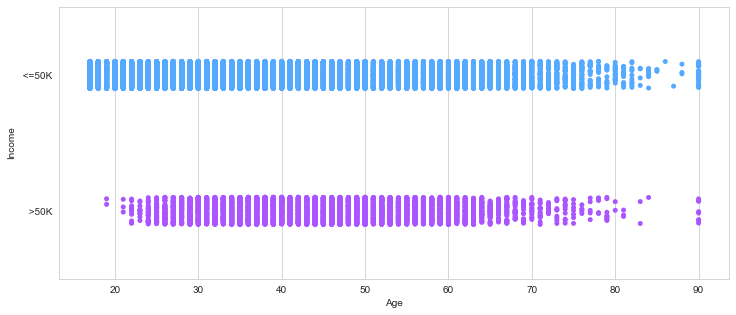

In [83]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Age', y = 'Income',palette='cool', data=df)
plt.show()

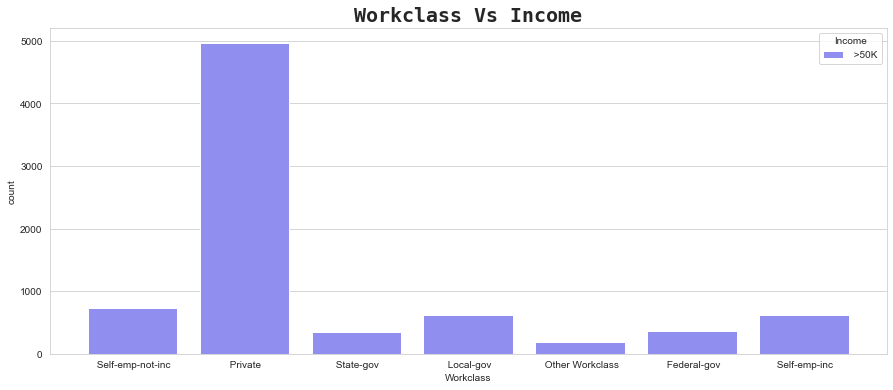

In [70]:
plt.figure(figsize=(15,6))
plt.title('Workclass Vs Income',fontdict={'fontname': 'Monospace', 'fontsize': 20, 'fontweight': 'bold'})
sns.countplot(x ="Workclass", hue ="Income",palette='cool' ,data = df[df['Income']==' >50K'])
plt.plot();

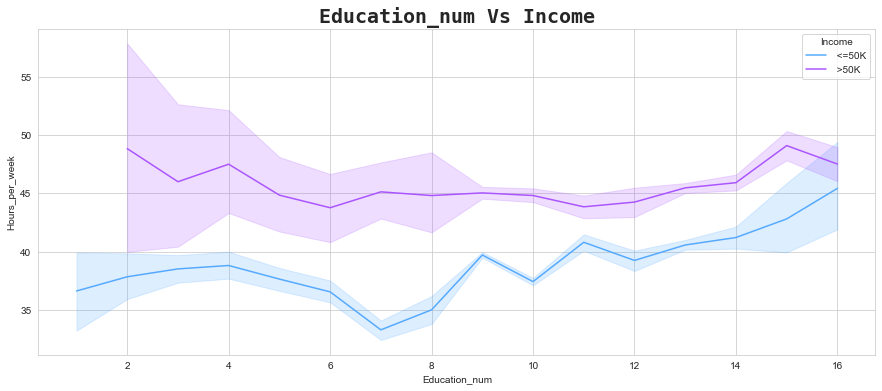

In [73]:
plt.figure(figsize=(15,6))
plt.title('Education_num Vs Income',fontdict={'fontname': 'Monospace', 'fontsize': 20, 'fontweight': 'bold'})
sns.lineplot(x ='Education_num', y='Hours_per_week',hue ="Income",palette='cool' ,data = df)
plt.plot();

people who earns more than 50k, work more than 43hr a week whereas people who earn less than 50k works below 40hr in week.

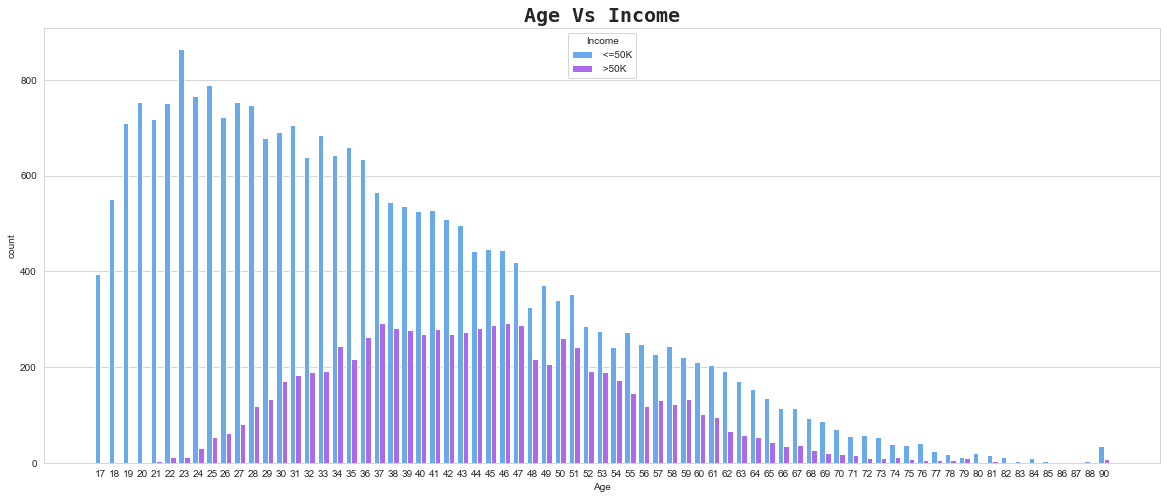

In [78]:
plt.figure(figsize=(20,8))
plt.title('Age Vs Income',fontdict={'fontname': 'Monospace', 'fontsize': 20, 'fontweight': 'bold'})
sns.countplot(x ="Age", hue ="Income",palette='cool' ,data = df)
plt.plot();

people who earned more than 50k has a age group of 31-55(mostly).

We can observe that people who has the age group of 17-31 generally earns less than 50k.

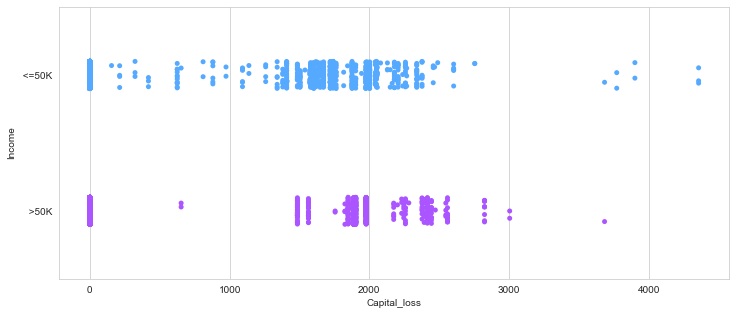

In [82]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Capital_loss', y = 'Income',palette='cool', data=df)
plt.show()

In the above strip plot we can see that the capital loss for people with income >50K is considerably less than people with income <=50K


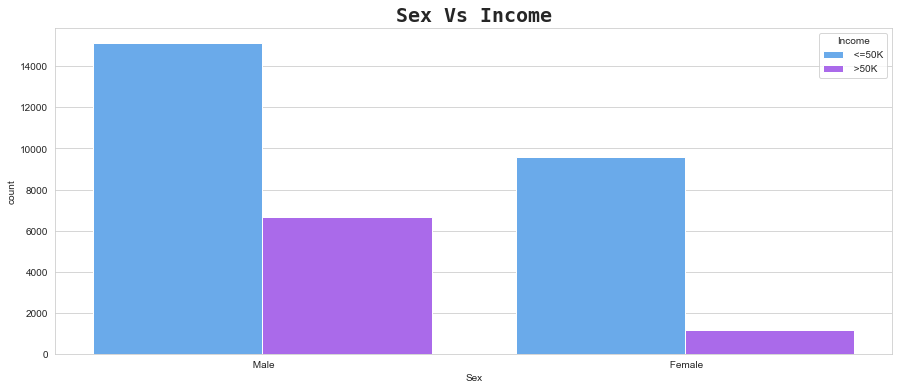

In [81]:
plt.figure(figsize=(15,6))
plt.title('Sex Vs Income',fontdict={'fontname': 'Monospace', 'fontsize': 20, 'fontweight': 'bold'})
sns.countplot(x ="Sex", hue ="Income",palette='cool' ,data = df)
plt.plot();

Males earned more than 50k as compared to Female.

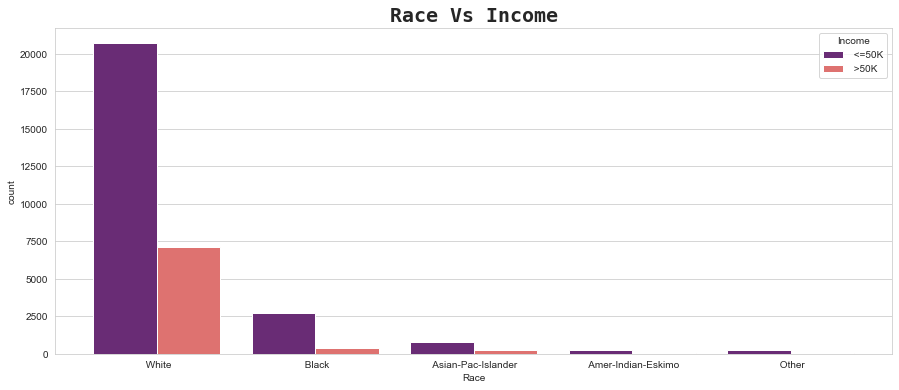

In [86]:
plt.figure(figsize=(15,6))
plt.title('Race Vs Income',fontdict={'fontname': 'Monospace', 'fontsize': 20, 'fontweight': 'bold'})
sns.countplot(x ="Race", hue ="Income",palette='magma' ,data = df)
plt.plot();

White people are the highest earnes. Approx 7000 of white people earns more than 50k.

For, black people majority of than earns less than 50k.

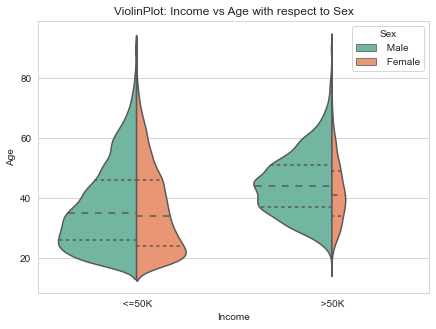

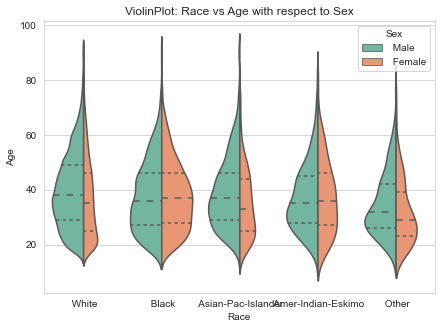

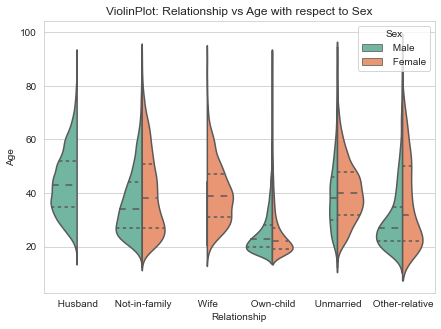

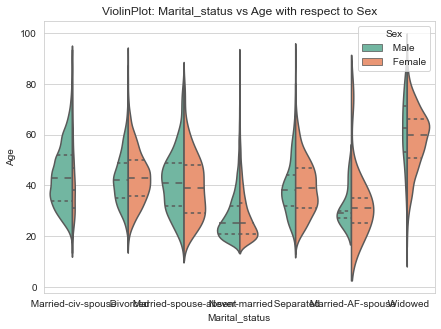

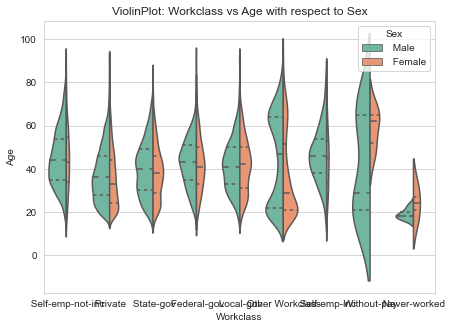

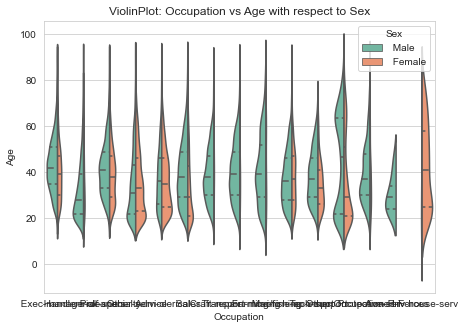

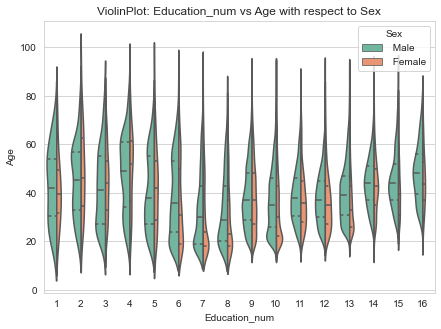

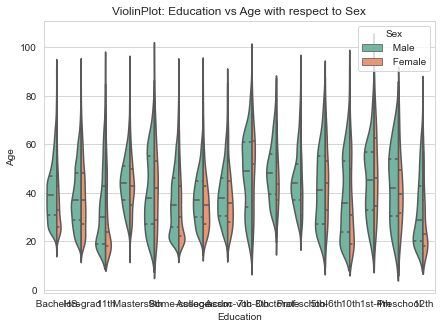

In [90]:
col=["Income","Race","Relationship","Marital_status","Workclass","Occupation","Education_num","Education"]
for x in df[col]:
    plt.figure(figsize=(7,5))
    sns.violinplot(x, y="Age", hue="Sex", data=df, palette="Set2", split=True, scale="count", inner="quartile")
    plt.title(f"ViolinPlot: {x} vs Age with respect to Sex")
    plt.show()

In first violinplot shows us that male in any age group and income group have a higher number than their female counterparts.

In second violinplot shows us that female with black ethinicity of any age group is higher than the other ethinicity group females.

In third violin plot shows us that people in the own child relationship age from 10-40. Also we have female who are unmarried more than the male counter parts.

In Forth violin plot shows us that the marital status as married spouse have a higher number in male than in female and people who are widowed have a higher number in females as compared to the males.
    
In Fifth violin plot shows us that male cover most of the working class sectors in each category as compared to the females.

In sixth violin plot shows us that the designation of private house services has more number of female mostly from the 20-60 age group while occupations such as craft repair, transport moving, farming/fishing, protective/security service and armed forces have a larger number of data coverage for males.

In seventh violin plot shows us that males in all age group have a higher education number compared to their female counter parts.

In eighth violin plot shows us that just like the education number the education category sees more number of males than their female counter parts giving us a red flag on how female education is a concern.



# checking the data distribution

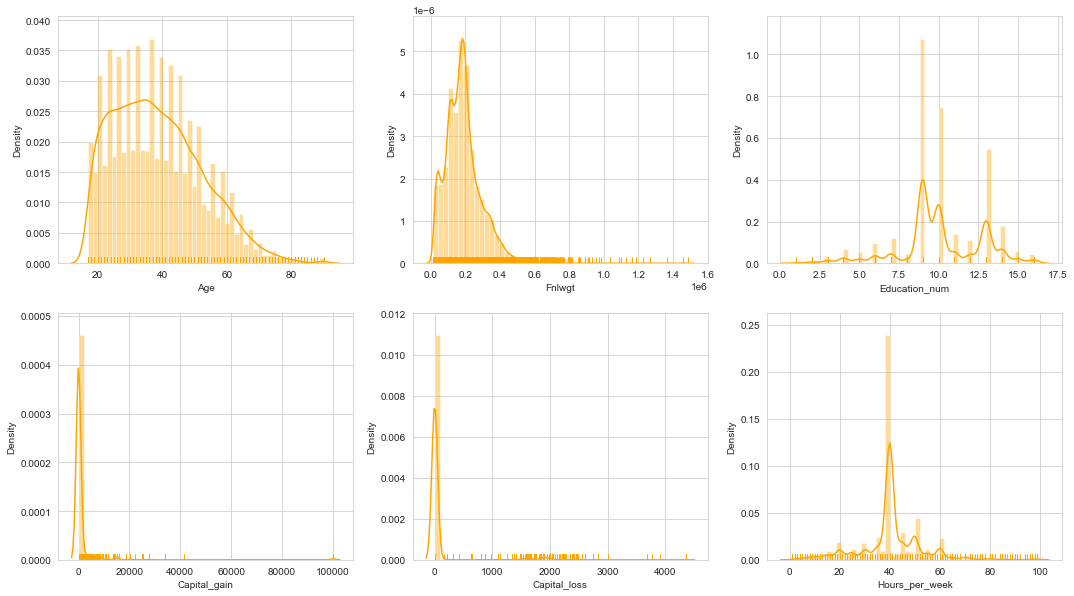

In [95]:
plt.figure(figsize=(18,10))
plot=1
for col in num_dtype:
    if plot<=6:
        plt.subplot(2,3,plot)
        sns.distplot(df[col],color='orange', rug=True)
        plt.xlabel(col)
        plot=plot+1
plt.show();

1-Age and Fnlwgt are right skewed.

2-Education_num has variation, which need treatment.

3-captital_gain & Capital_loss are highly right skewed with majority values are zero.

4- Although Hours_per_week seems Normal Distributed but it shows some variation in so, we need to treat.

# Encoding the object datatype

In [7]:
# Label Encoder

LE = LabelEncoder()
df["Income"] = LE.fit_transform(df["Income"])
# Ordinal Encoder

OE = OrdinalEncoder()
df['Workclass'] = OE.fit_transform(df['Workclass'].values.reshape(-1,1))
df['Education'] = OE.fit_transform(df['Education'].values.reshape(-1,1))
df['Marital_status'] = OE.fit_transform(df['Marital_status'].values.reshape(-1,1))
df['Occupation'] = OE.fit_transform(df['Occupation'].values.reshape(-1,1))
df['Relationship'] = OE.fit_transform(df['Relationship'].values.reshape(-1,1))
df['Native_country'] = OE.fit_transform(df['Native_country'].values.reshape(-1,1))
df['Race'] = OE.fit_transform(df['Race'].values.reshape(-1,1))
df['Sex'] = OE.fit_transform(df['Sex'].values.reshape(-1,1))
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,6.0,83311,9.0,13,2.0,3.0,0.0,4.0,1.0,0,0,13,39.0,0
1,38,4.0,215646,11.0,9,0.0,5.0,1.0,4.0,1.0,0,0,40,39.0,0
2,53,4.0,234721,1.0,7,2.0,5.0,0.0,2.0,1.0,0,0,40,39.0,0
3,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,4.0,0
4,37,4.0,284582,12.0,14,2.0,3.0,5.0,4.0,0.0,0,0,40,39.0,0


I could have used one hot encoder here but I preferred to use OrdinalEncoder to ensure that the number of columns do not get increased unnecessarily.

In [99]:
df.shape

(32560, 15)

In [100]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

I am checking the number of rows and columns present in our dataset after applying the enconding techniques and ensuring that there are no null values present in them.

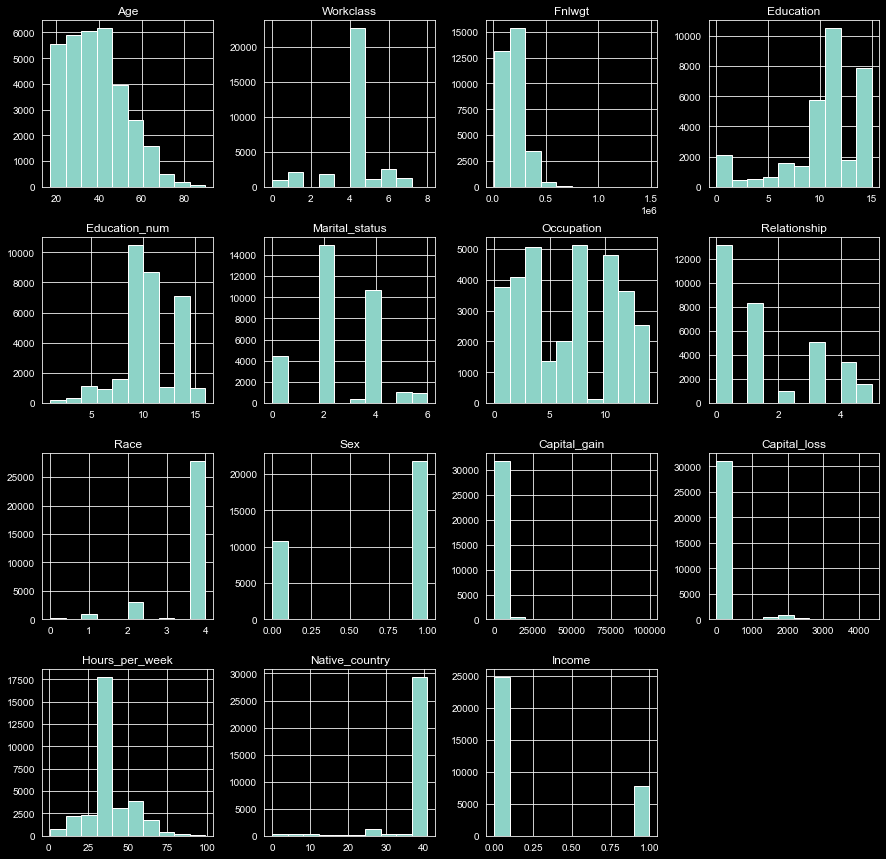

In [109]:
plt.style.use(['dark_background'])
df.hist(figsize=(15,15))
plt.show()

# Removing outliers usinf Z score

In [8]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

# Skew method

In [9]:
df.skew()

Age                0.558738
Workclass         -0.659289
Fnlwgt             1.446972
Education         -0.934063
Education_num     -0.311630
Marital_status    -0.013448
Occupation         0.089926
Relationship       0.786784
Race              -2.435332
Sex               -0.719244
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
Native_country    -3.898452
Income             1.212383
dtype: float64

# Fix skew using log transform

In [10]:
for col in num_dtype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

Succesfully applied Log Transformation on our numerical datatype

In [11]:
df.skew()

Age              -0.113322
Workclass        -0.659289
Fnlwgt           -0.842559
Education        -0.934063
Education_num    -0.311630
Marital_status   -0.013448
Occupation        0.089926
Relationship      0.786784
Race             -2.435332
Sex              -0.719244
Capital_gain      3.096803
Capital_loss      4.307460
Hours_per_week    0.227636
Native_country   -3.898452
Income            1.212383
dtype: float64

# Splitting Data into Input and Output Variable

In [12]:
X = df.drop('Income', axis=1)
Y = df['Income']

I have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

# Adding few samples

In [13]:
#making all the categorical label values equal

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [14]:
Y.value_counts()

0    24719
1    24719
Name: Income, dtype: int64

# Scaling


In [15]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Getting best random state for building Classification Models

In [26]:
def model_func(model,X,Y):
    max_accuracy=0
    for i in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.20,random_state=i,stratify=Y)
        #x_train,y_train=SMOTE().fit_resample(x_train,y_train) ##over sampling of our Data
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        accuracy_check=accuracy_score(y_test,pred)
        if accuracy_check>max_accuracy:
            max_accuracy=accuracy_check
            final_r=i
    print('max accuracy score corresponding to',final_r,'is',max_accuracy*100)
    print('\n')
    print('cross validation score',cross_val_score(model,X,Y,scoring='accuracy').mean()*100)
    print('\n')
    print('Standard Deviation',cross_val_score(model,X,Y,scoring='accuracy').std()*100)
    print('\n')
    print('F1 score',f1_score(y_test,pred)*100)
    print('\n')
    print('Training accuracy',model.score(x_train,y_train)*100)
    print('\n')
    print('Test Accuracy',model.score(x_test,y_test)*100)
    print('\n')
    print('Confusion Matrix',confusion_matrix(y_test,pred))
    print('\n')
    print('Classification Report',classification_report(y_test,pred))
    print('\n')
    print('Roc_auc Score',roc_auc_score(y_test,pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pred)
    roc_auc = auc( false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate,label = "AUC = %0.2f"% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc = 'lower right')
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    print("\n\n")
    return final_r

max accuracy score corresponding to 85 is 78.20590614886731


cross validation score 77.43235269712804


Standard Deviation 0.5220352415860972


F1 score 77.98929208804283


Training accuracy 77.448798988622


Test Accuracy 77.5485436893204


Confusion Matrix [[3735 1209]
 [1011 3933]]


Classification Report               precision    recall  f1-score   support

           0       0.79      0.76      0.77      4944
           1       0.76      0.80      0.78      4944

    accuracy                           0.78      9888
   macro avg       0.78      0.78      0.78      9888
weighted avg       0.78      0.78      0.78      9888



Roc_auc Score 0.7754854368932038





85

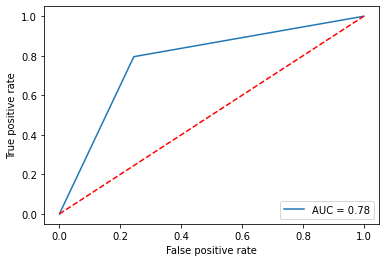

In [19]:
model_func(LogisticRegression(),X,Y)

max accuracy score corresponding to 98 is 86.22572815533981


cross validation score 84.67790830069102


Standard Deviation 4.2033458228417855


F1 score 85.34326555264748


Training accuracy 99.99747155499368


Test Accuracy 85.27508090614887


Confusion Matrix [[4193  751]
 [ 705 4239]]


Classification Report               precision    recall  f1-score   support

           0       0.86      0.85      0.85      4944
           1       0.85      0.86      0.85      4944

    accuracy                           0.85      9888
   macro avg       0.85      0.85      0.85      9888
weighted avg       0.85      0.85      0.85      9888



Roc_auc Score 0.8527508090614888





98

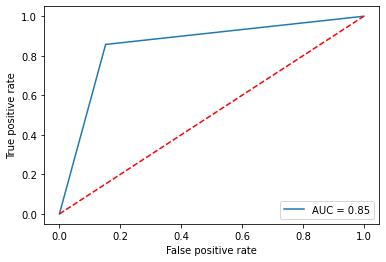

In [20]:
model_func(DecisionTreeClassifier(),X,Y)

max accuracy score corresponding to 82 is 79.49029126213593


cross validation score 78.54892219785845


Standard Deviation 0.902974089211469


F1 score 78.60446410617334


Training accuracy 78.64475347661188


Test Accuracy 78.47896440129449


Confusion Matrix [[3851 1093]
 [1035 3909]]


Classification Report               precision    recall  f1-score   support

           0       0.79      0.78      0.78      4944
           1       0.78      0.79      0.79      4944

    accuracy                           0.78      9888
   macro avg       0.78      0.78      0.78      9888
weighted avg       0.78      0.78      0.78      9888



Roc_auc Score 0.7847896440129449





82

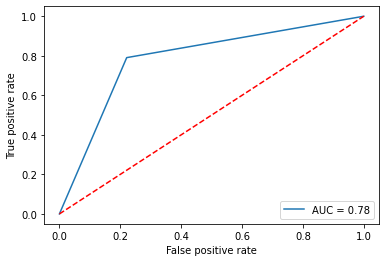

In [18]:
model_func(GaussianNB(),X,Y)

max accuracy score corresponding to 95 is 90.54409385113269


cross validation score 90.02193086898129


Standard Deviation 2.7371400026699644


F1 score 89.37313432835822


Training accuracy 99.99747155499368


Test Accuracy 89.19902912621359


Confusion Matrix [[4329  615]
 [ 453 4491]]


Classification Report               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4944
           1       0.88      0.91      0.89      4944

    accuracy                           0.89      9888
   macro avg       0.89      0.89      0.89      9888
weighted avg       0.89      0.89      0.89      9888



Roc_auc Score 0.8919902912621359





95

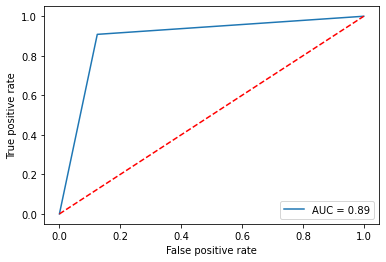

In [28]:
model_func(ExtraTreesClassifier(),X,Y)

max accuracy score corresponding to 42 is 86.22572815533981


cross validation score 85.49301074635288


Standard Deviation 2.329435186382303


F1 score 86.27565982404691


Training accuracy 85.88369152970922


Test Accuracy 85.80097087378641


Confusion Matrix [[4071  873]
 [ 531 4413]]


Classification Report               precision    recall  f1-score   support

           0       0.88      0.82      0.85      4944
           1       0.83      0.89      0.86      4944

    accuracy                           0.86      9888
   macro avg       0.86      0.86      0.86      9888
weighted avg       0.86      0.86      0.86      9888



Roc_auc Score 0.858009708737864





42

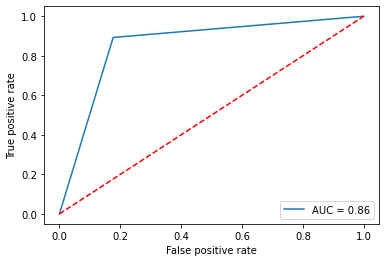

In [29]:
model_func(AdaBoostClassifier(),X,Y)

max accuracy score corresponding to 42 is 91.02953074433657


cross validation score 89.06526291593387


Standard Deviation 5.670509968468461


F1 score 90.27833803953206


Training accuracy 91.20101137800253


Test Accuracy 90.25080906148867


Confusion Matrix [[4448  496]
 [ 468 4476]]


Classification Report               precision    recall  f1-score   support

           0       0.90      0.90      0.90      4944
           1       0.90      0.91      0.90      4944

    accuracy                           0.90      9888
   macro avg       0.90      0.90      0.90      9888
weighted avg       0.90      0.90      0.90      9888



Roc_auc Score 0.9025080906148867





42

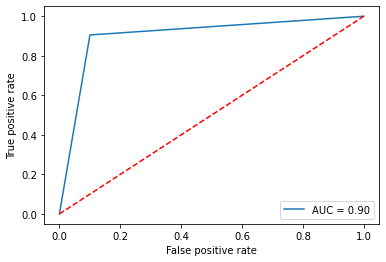

In [27]:
#LGBM Classifier
model=lgb.LGBMClassifier()
model_func(model, X, Y)

# Hyper parameter tuning on ExtraTreesClassifier model

In [37]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=84,test_size=.20,stratify=Y)

etc=ExtraTreesClassifier()

param={'criterion' : ['gini', 'entropy'],'n_jobs' : [-2, -1, 1],'random_state' : [42, 739, 1000],'max_depth' : [0, 15, 30],'n_estimators' : [100, 200, 300]}

grid=GridSearchCV(estimator=etc,param_grid=param,scoring='accuracy',n_jobs=-1)

grid.fit(x_train,y_train)

grid.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'n_estimators': 300,
 'n_jobs': -2,
 'random_state': 42}

In [41]:
etc_final=ExtraTreesClassifier(criterion='gini',max_depth=30,n_estimators=300,n_jobs=-2,random_state=42)
etc_final.fit(x_train,y_train)
pred=etc_final.predict(x_test)
print('Final Accuracy_score :',accuracy_score(pred,y_test)*100)
print('\n')
print('Final f_1 score :',f1_score(pred,y_test)*100)
print('\n')
print('Final roc_auc score :',roc_auc_score(pred,y_test)*100)
print('\n')
print('Final classification Report :',classification_report(pred,y_test))
print('\n')
print('Final confusion Matrix :',confusion_matrix(pred,y_test))

Final Accuracy_score : 89.90695792880258


Final f_1 score : 90.2577118313159


Final roc_auc score : 90.11495122633285


Final classification Report :               precision    recall  f1-score   support

           0       0.86      0.93      0.90      4588
           1       0.94      0.87      0.90      5300

    accuracy                           0.90      9888
   macro avg       0.90      0.90      0.90      9888
weighted avg       0.90      0.90      0.90      9888



Final confusion Matrix : [[4267  321]
 [ 677 4623]]


So, my final accuracy score is 89.9% ~ 90% which may be less than before but the F1 score has been increased.

# AUC ROC Curve

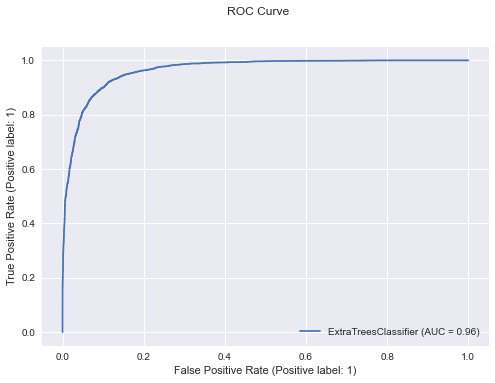

In [44]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(etc_final, x_test, y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

AUC score for my final model to be of 96%

# Saving the model

In [45]:
file = "Census income project.pkl"
joblib.dump(etc_final, file)

['Census income project.pkl']